In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'

BEST_SINGLE_MNIST_XS = {
    "trial": "best_single_mnist_xs", # 3800 LUTs
    "accuracy": 93.04,
    "loss": 0.236, 
    "ensemble_size": 1,
    "model_size": "mnist_xs",
}
BEST_SINGLE_MNIST_XS_NON_SHARED = {
    "trial": "best_single_mnist_xs", # 3800 LUTs
    "accuracy": 93.04,
    "loss": 0.236, 
    "ensemble_size": 1,
    "model_size": "mnist_xs_non_shared",
}
BEST_SINGLE_MNIST_S = {
    "trial": "best_single_mnist_s", 
    "accuracy": 95.83,
    "loss": 0.152, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "mnist_s",
}
BEST_SINGLE_MNIST_M = {
    "trial": "best_single_mnist_m", # 45,662 LUTs
    "accuracy": 96.57,
    "loss": 0.127, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "mnist_m",
}
BEST_SINGLE_MNIST_L = {
    "trial": "best_single_mnist_l",
    "accuracy": 97.78,
    "loss": 0.089, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "mnist_l",
}
BEST_SINGLE_MNIST_XS_DF = pd.DataFrame(BEST_SINGLE_MNIST_XS, index=[0])
BEST_SINGLE_MNIST_XS_NON_SHARED_DF = pd.DataFrame(BEST_SINGLE_MNIST_XS_NON_SHARED, index=[0])
BEST_SINGLE_MNIST_S_DF = pd.DataFrame(BEST_SINGLE_MNIST_S, index=[0])
BEST_SINGLE_MNIST_M_DF = pd.DataFrame(BEST_SINGLE_MNIST_M, index=[0])
BEST_SINGLE_MNIST_L_DF = pd.DataFrame(BEST_SINGLE_MNIST_L, index=[0])

In [3]:
def parse_single_model_experiment(experiment_dir):
    """
    Parse single model experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,model_size\n")
    for acc_f in accuracy_files:
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        # Get model size
        if "mnist_xs" in txt_file:
            model_size = "mnist_xs"
        elif "mnist_s1.1" in txt_file:
            model_size = "mnist_s1.1"
        elif "mnist_s" in txt_file:
            model_size = "mnist_s"
        elif "mnist_m" in txt_file:
            model_size = "mnist_m"
        elif "mnist_m1.1" in txt_file:
            model_size = "mnist_m1.1"
        elif "mnist_m1.2" in txt_file:
            model_size = "mnist_m1.1"
        elif "mnist_l" in txt_file:
            model_size = "mnist_l"
        elif "mnist_l1.1" in txt_file:
            model_size = "mnist_l1.1"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        ensemble_size = int(re.findall(f"\d+", txt_file)[0])
        # Get model size
        if "xs_shared_input" in txt_file:
            model_size = "mnist_xs_shared_input"
        elif "xs_non_shared" in txt_file:
            model_size = "mnist_xs_non_shared"
        elif "small" in txt_file:
            model_size = "mnist_s"
        elif "xs" in txt_file:
            model_size = "mnist_xs"
        elif "non_shared_l" in txt_file:
            model_size = "mnist_l_non_shared"
        elif "averaging_l" in txt_file:
            model_size = "mnist_l"
        elif "med" in txt_file:
            model_size = "mnist_m"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_seq_ensemble_exp(experiment_dir):
    """
    Parse sequentially trained ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        # Get model size
        if "xs" in trial:
            model_size = "mnist_xs"
        # Get accuracy, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Ensemble size" in l and "Accuracy" in l:
                    ensemble_size = re.findall(f"Ensemble size \d+", l)[0]
                    ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                    loss = float(re.findall(f"\d+\.\d+", l)[0])
                    acc = float(re.findall(f"\d+\.\d+", l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {acc:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df 

def add_single_model_data(df):
    """
    Concat single model dataframes to given dataframe
    """
    df = pd.concat([df, BEST_SINGLE_MNIST_XS_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_XS_NON_SHARED_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_S_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_M_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_L_DF], ignore_index=True)
    return df

## Single Models

In [28]:
experiment_dir = "../mnist_single_models"
df = parse_single_model_experiment(experiment_dir)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
df

,trial,accuracy,loss,model_size
0,mnist_l1.1,97.78,0.089,mnist_l
1,mnist_m1.1,97.57,0.100,mnist_m
2,mnist_m,96.57,0.127,mnist_m
3,mnist_l,96.48,0.151,mnist_l
4,mnist_s,95.83,0.152,mnist_s
5,mnist_m1.2,94.07,0.211,mnist_m
6,mnist_s1.1,93.97,0.213,mnist_s1.1
7,mnist_xs,93.04,0.236,mnist_xs


## Averaging

In [4]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,non_shared_l_ensemble_size32,98.57,0.048,32,mnist_l_non_shared
1,averaging_l_ensemble_size8,98.55,0.080,8,mnist_l
2,non_shared_l_ensemble_size16,98.52,0.051,16,mnist_l_non_shared
3,averaging_l_ensemble_size4,98.48,0.082,4,mnist_l
4,non_shared_l_ensemble_size4,98.36,0.085,4,mnist_l_non_shared
5,averaging_l_ensemble_size2,98.30,0.080,2,mnist_l
6,non_shared_l_ensemble_size2,98.28,0.082,2,mnist_l_non_shared
7,averaging_xs_non_shared_ensemble_size64,98.25,0.059,64,mnist_xs_non_shared
8,averaging_xs_non_shared_ensemble_size32,97.92,0.073,32,mnist_xs_non_shared
9,best_single_mnist_l,97.78,0.089,1,mnist_l


,trial,accuracy,loss,ensemble_size,model_size
0,non_shared_l_ensemble_size32,98.57,0.048,32,mnist_l_non_shared
1,averaging_l_ensemble_size8,98.55,0.080,8,mnist_l
2,non_shared_l_ensemble_size16,98.52,0.051,16,mnist_l_non_shared
3,averaging_l_ensemble_size4,98.48,0.082,4,mnist_l
4,non_shared_l_ensemble_size4,98.36,0.085,4,mnist_l_non_shared
5,averaging_l_ensemble_size2,98.30,0.080,2,mnist_l
6,non_shared_l_ensemble_size2,98.28,0.082,2,mnist_l_non_shared
7,averaging_xs_non_shared_ensemble_size64,98.25,0.059,64,mnist_xs_non_shared
8,averaging_xs_non_shared_ensemble_size32,97.92,0.073,32,mnist_xs_non_shared
9,best_single_mnist_l,97.78,0.089,1,mnist_l


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


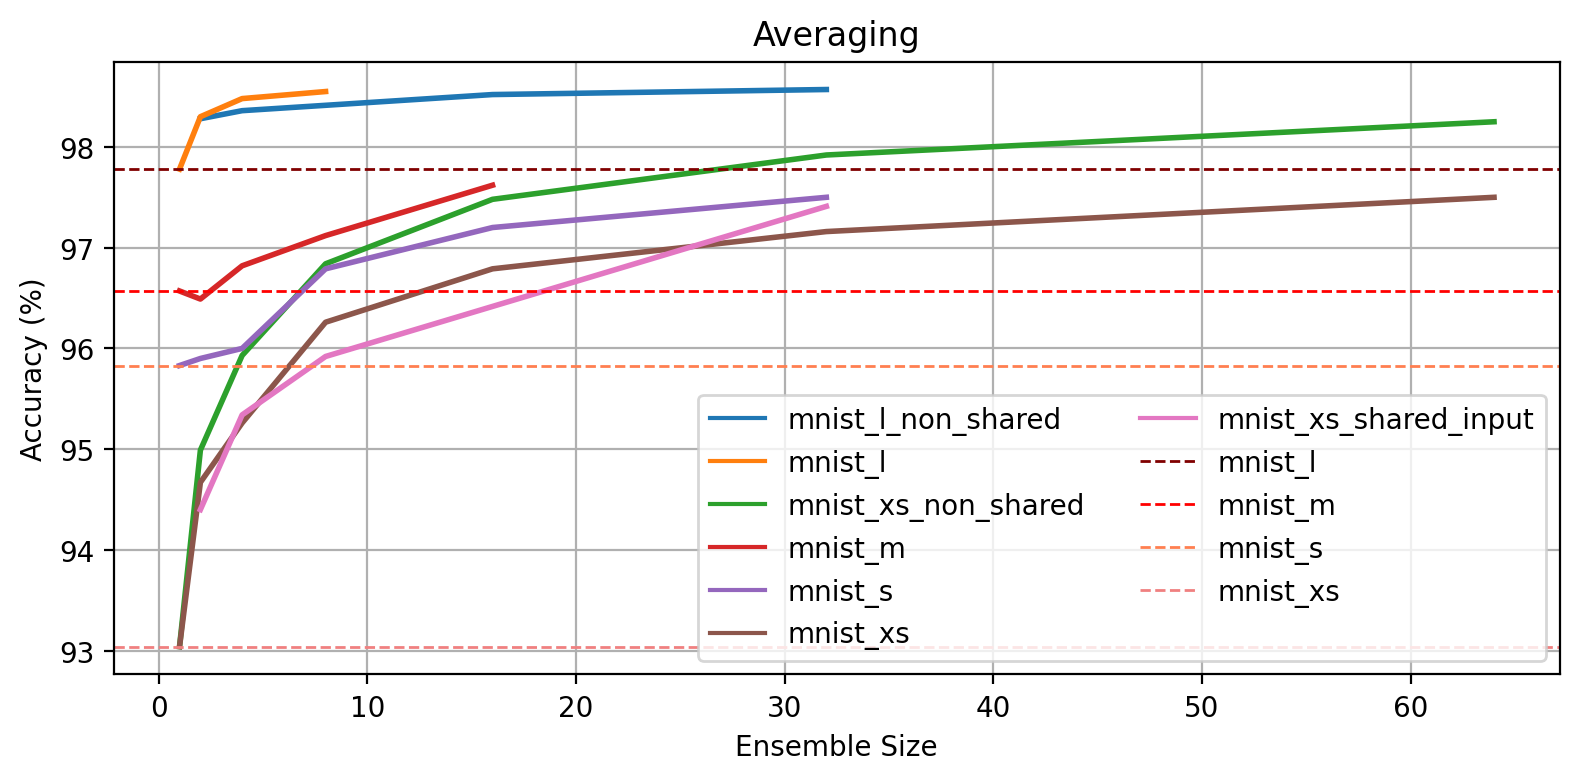

In [5]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # label="JSC-S Ensemble"
)
plt.axhline(y=BEST_SINGLE_MNIST_L["accuracy"], linewidth=1, linestyle="--", color="maroon", label="mnist_l")
plt.axhline(y=BEST_SINGLE_MNIST_M["accuracy"], linewidth=1, linestyle="--", color="red", label="mnist_m")
plt.axhline(y=BEST_SINGLE_MNIST_S["accuracy"], linewidth=1, linestyle="--", color="coral", label="mnist_s")
plt.axhline(y=BEST_SINGLE_MNIST_XS["accuracy"], linewidth=1, linestyle="--", color="lightcoral", label="mnist_xs")
ax.grid()
ax.legend(ncol=2)
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
# ax.set_xscale("log")
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")

## Bagging

In [31]:
experiment_dir = "../bagging"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
bagging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,best_single_mnist_l,97.78,0.089,1,mnist_l
1,bagging_xs_ensemble_size16,96.68,0.117,15,mnist_xs
2,bagging_xs_ensemble_size16,96.64,0.117,16,mnist_xs
3,bagging_xs_ensemble_size16,96.63,0.118,12,mnist_xs
4,bagging_xs_ensemble_size16,96.59,0.117,14,mnist_xs
5,bagging_xs_ensemble_size16,96.58,0.117,13,mnist_xs
6,best_single_mnist_m,96.57,0.127,1,mnist_m
7,bagging_xs_ensemble_size16,96.56,0.119,11,mnist_xs
8,bagging_xs_ensemble_size16,96.47,0.120,10,mnist_xs
9,bagging_xs_ensemble_size16,96.39,0.121,9,mnist_xs


,trial,accuracy,loss,ensemble_size,model_size
0,best_single_mnist_l,97.78,0.089,1,mnist_l
1,bagging_xs_ensemble_size16,96.68,0.117,15,mnist_xs
2,bagging_xs_ensemble_size16,96.64,0.117,16,mnist_xs
3,bagging_xs_ensemble_size16,96.63,0.118,12,mnist_xs
4,bagging_xs_ensemble_size16,96.59,0.117,14,mnist_xs
5,bagging_xs_ensemble_size16,96.58,0.117,13,mnist_xs
6,best_single_mnist_m,96.57,0.127,1,mnist_m
7,bagging_xs_ensemble_size16,96.56,0.119,11,mnist_xs
8,bagging_xs_ensemble_size16,96.47,0.120,10,mnist_xs
9,bagging_xs_ensemble_size16,96.39,0.121,9,mnist_xs


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


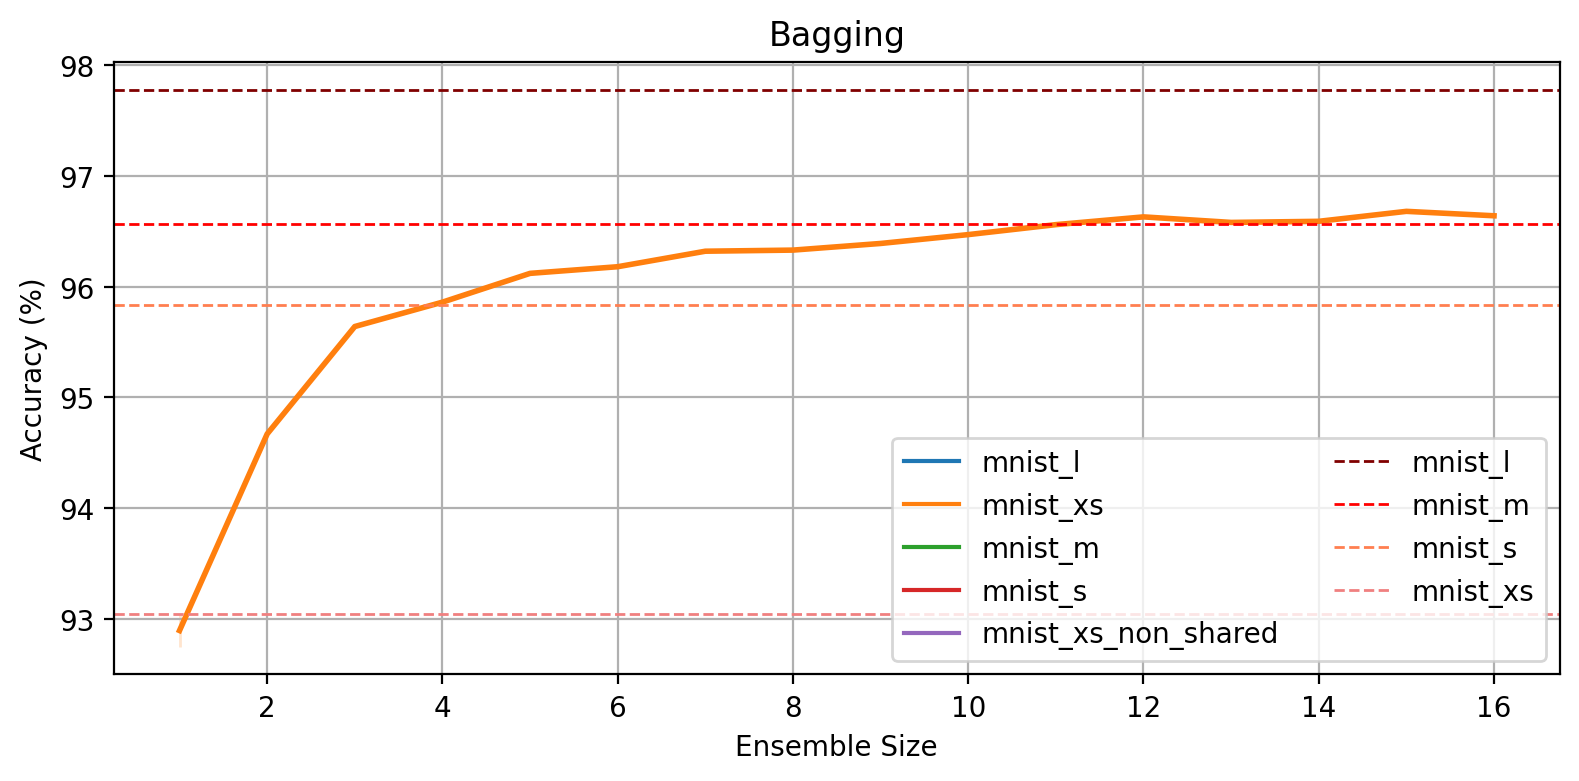

In [32]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
)
plt.axhline(y=BEST_SINGLE_MNIST_L["accuracy"], linewidth=1, linestyle="--", color="maroon", label="mnist_l")
plt.axhline(y=BEST_SINGLE_MNIST_M["accuracy"], linewidth=1, linestyle="--", color="red", label="mnist_m")
plt.axhline(y=BEST_SINGLE_MNIST_S["accuracy"], linewidth=1, linestyle="--", color="coral", label="mnist_s")
plt.axhline(y=BEST_SINGLE_MNIST_XS["accuracy"], linewidth=1, linestyle="--", color="lightcoral", label="mnist_xs")
ax.grid()
ax.legend(ncol=2)
ax.set_title("Bagging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
# ax.set_xscale("log")
fig.tight_layout()
plt.savefig("bagging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("bagging_acc_v_ensemble_size_lineplot.png")

## AdaBoost

In [33]:
experiment_dir = "../adaboost"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
adaboost_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,best_single_mnist_l,97.78,0.089,1,mnist_l
1,best_single_mnist_m,96.57,0.127,1,mnist_m
2,adaboost_xs_ensemble_size16,96.15,1.451,15,mnist_xs
3,adaboost_xs_ensemble_size16,96.14,1.451,14,mnist_xs
4,adaboost_xs_ensemble_size16,96.07,1.451,13,mnist_xs
5,adaboost_xs_ensemble_size16,95.99,1.451,12,mnist_xs
6,adaboost_xs_ensemble_size16,95.95,1.451,11,mnist_xs
7,adaboost_xs_ensemble_size16,95.92,1.451,10,mnist_xs
8,adaboost_xs_ensemble_size16,95.84,1.451,9,mnist_xs
9,best_single_mnist_s,95.83,0.152,1,mnist_s


,trial,accuracy,loss,ensemble_size,model_size
0,best_single_mnist_l,97.78,0.089,1,mnist_l
1,best_single_mnist_m,96.57,0.127,1,mnist_m
2,adaboost_xs_ensemble_size16,96.15,1.451,15,mnist_xs
3,adaboost_xs_ensemble_size16,96.14,1.451,14,mnist_xs
4,adaboost_xs_ensemble_size16,96.07,1.451,13,mnist_xs
5,adaboost_xs_ensemble_size16,95.99,1.451,12,mnist_xs
6,adaboost_xs_ensemble_size16,95.95,1.451,11,mnist_xs
7,adaboost_xs_ensemble_size16,95.92,1.451,10,mnist_xs
8,adaboost_xs_ensemble_size16,95.84,1.451,9,mnist_xs
9,best_single_mnist_s,95.83,0.152,1,mnist_s


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


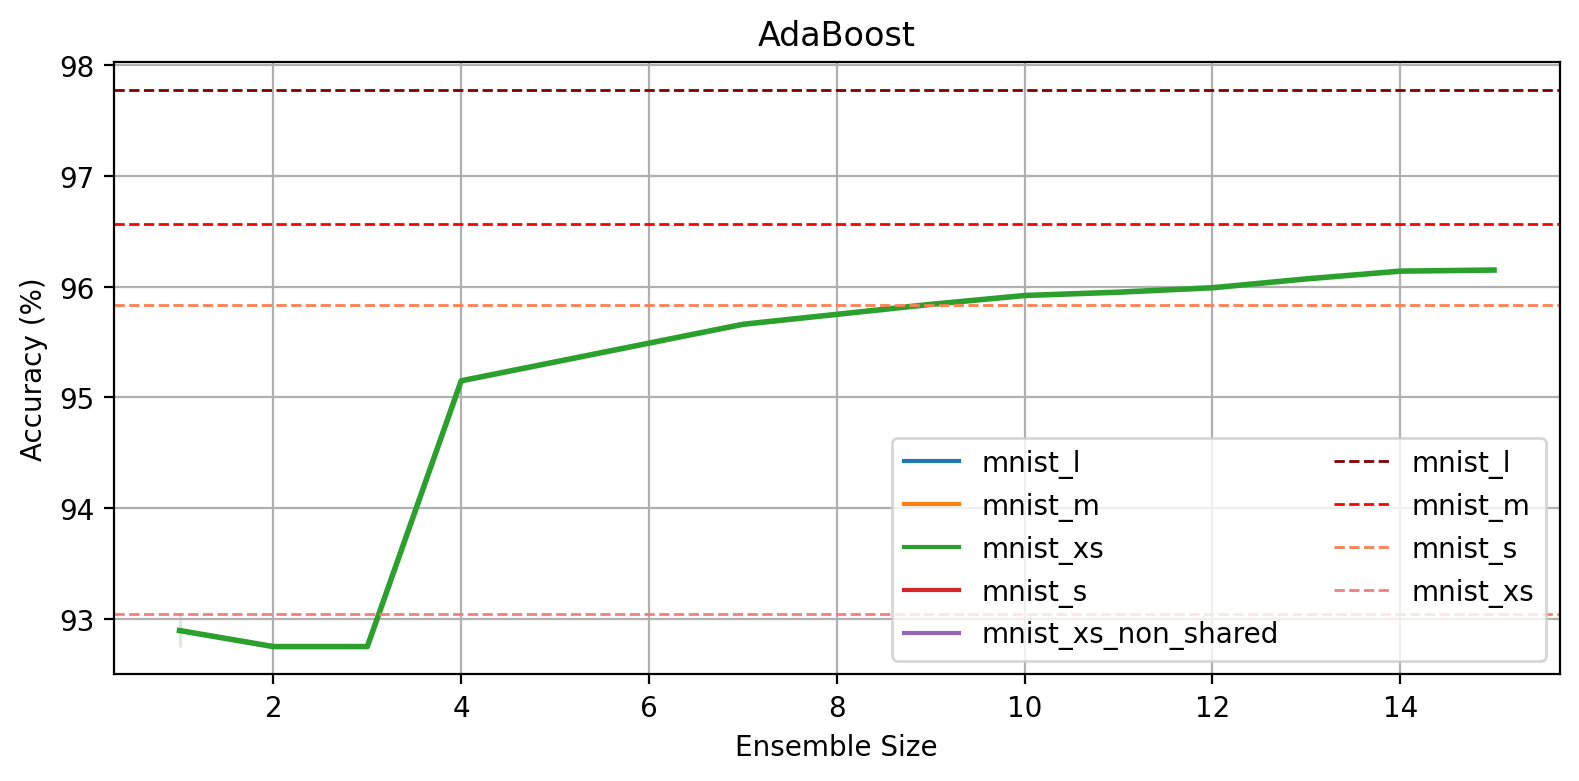

In [34]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
)
plt.axhline(y=BEST_SINGLE_MNIST_L["accuracy"], linewidth=1, linestyle="--", color="maroon", label="mnist_l")
plt.axhline(y=BEST_SINGLE_MNIST_M["accuracy"], linewidth=1, linestyle="--", color="red", label="mnist_m")
plt.axhline(y=BEST_SINGLE_MNIST_S["accuracy"], linewidth=1, linestyle="--", color="coral", label="mnist_s")
plt.axhline(y=BEST_SINGLE_MNIST_XS["accuracy"], linewidth=1, linestyle="--", color="lightcoral", label="mnist_xs")
ax.grid()
ax.legend(ncol=2)
ax.set_title("AdaBoost")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.png")

## Ensembling Comparison

In [35]:
averaging_df["ensemble_method"] = averaging_df["model_size"].apply(lambda x: "Averaging")
bagging_df["ensemble_method"] = bagging_df["model_size"].apply(lambda x: "Bagging")
adaboost_df["ensemble_method"] = adaboost_df["model_size"].apply(lambda x: "AdaBoost")
all_df = pd.concat([averaging_df, bagging_df, adaboost_df])
all_df = add_single_model_data(all_df)
all_df

,trial,accuracy,loss,ensemble_size,model_size,ensemble_method
0,averaging_xs_non_shared_ensemble_size64,98.25,0.059,64,mnist_xs_non_shared,Averaging
1,averaging_xs_non_shared_ensemble_size32,97.92,0.073,32,mnist_xs_non_shared,Averaging
2,best_single_mnist_l,97.78,0.089,1,mnist_l,Averaging
3,averaging_med_ensemble_size16,97.62,0.108,16,mnist_m,Averaging
4,averaging_small_ensemble_size32,97.50,0.123,32,mnist_s,Averaging
...,...,...,...,...,...,...
71,best_single_mnist_xs,93.04,0.236,1,mnist_xs,NaN
72,best_single_mnist_xs,93.04,0.236,1,mnist_xs_non_shared,NaN
73,best_single_mnist_s,95.83,0.152,1,mnist_s,NaN
74,best_single_mnist_m,96.57,0.127,1,mnist_m,NaN


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


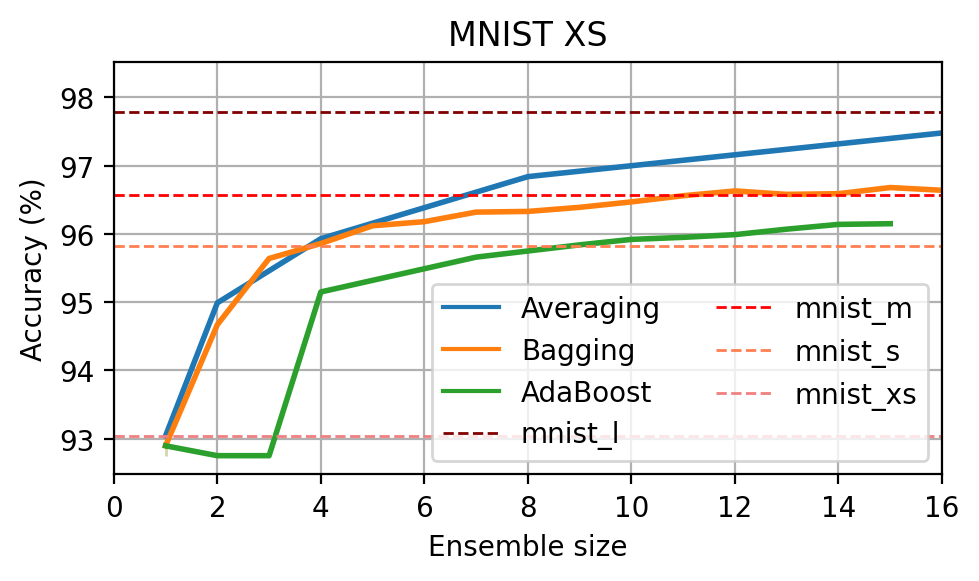

In [37]:
fig, ax = plt.subplots(figsize=(5, 3))

mnist_xs_df = averaging_df[averaging_df["model_size"] == "mnist_xs_non_shared"]
mnist_xs_df = pd.concat([mnist_xs_df, bagging_df[bagging_df["model_size"] == "mnist_xs"]])
mnist_xs_df = pd.concat([mnist_xs_df, adaboost_df[adaboost_df["model_size"] == "mnist_xs"]])
ax = sns.lineplot(
    data=mnist_xs_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    # errorbar=(lambda x: (x.min(), x.max())), 
    # err_kws={"linewidth": 2}, 
    linewidth=2,
)
plt.axhline(y=BEST_SINGLE_MNIST_L["accuracy"], linewidth=1, linestyle="--", color="maroon", label="mnist_l")
plt.axhline(y=BEST_SINGLE_MNIST_M["accuracy"], linewidth=1, linestyle="--", color="red", label="mnist_m")
plt.axhline(y=BEST_SINGLE_MNIST_S["accuracy"], linewidth=1, linestyle="--", color="coral", label="mnist_s")
plt.axhline(y=BEST_SINGLE_MNIST_XS["accuracy"], linewidth=1, linestyle="--", color="lightcoral", label="mnist_xs")

ax.grid()
ax.legend(loc="lower right", ncol=2)
# ax.set_ylim([69, 76])
ax.set_xlim([0, 16])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("MNIST XS")

fig.tight_layout()
plt.savefig("mnist_xs_all_acc_v_ensemble_size_lineplot.pdf")